## Hold shift and press Enter to run each cell :) 

In [26]:
import numpy as np
import scipy.io as sio
from scipy import signal
import os
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


 ## Required functions

In [60]:
####################
def myEDFread(path):
    fid=open(path,'rb')
    a=fid.read(236)
    ndr=int(fid.read(8)) #number of data records in sec
    drdur=float(fid.read(8)) #duration of each data record in sec
    ns=int(fid.read(4)) #number of signal channels
    Channels=[]
    for i in range(0,int(ns)):
        Channels.append(fid.read(16).decode('UTF-8')) # changing bytes to str
    tdu=fid.read(ns*80) #transducer type
    units=fid.read(ns*8) #physical dimensions
    phmn=[]
    phmx=[]
    dmn=[]
    dmx=[]
    for i in range(0,int(ns)):
        phmn.append(float(fid.read(8))) # physical min
    for i in range(0,int(ns)):
        phmx.append(float(fid.read(8))) # physical max
    for i in range(0,int(ns)):
        dmn.append(float(fid.read(8))) # digital min
    for i in range(0,int(ns)):
        dmx.append(float(fid.read(8))) # digital max
    scalefac=[]
    for i in range(0,len(phmn)):
        scalefac.append((phmx[i]-phmn[i])/(dmx[i]-dmn[i]))
    dc=[]
    for i in range(0,len(phmn)):
        dc.append(phmx[i]-scalefac[i]*dmx[i])
    prefilters=fid.read(ns*80) #prefilters 
    nr=[]
    for i in range(0,ns):
        nr.append(int(fid.read(8))) #samples per data record
    if sum(nr)/len(nr)==nr[0]:
        fs=nr[0]/int(drdur)
    else:
        disp('cannot proceed. one of the channels has a different sampling rate')
    othr=fid.read(ns*32)
    X=np.zeros((ns,int(nr[0]*ndr)))
    for i in range(0,ndr):
        for j in range(0,ns):
            X[j][i*nr[j]:(i+1)*nr[j]]=np.fromstring(fid.read(nr[j]*2),  'int16')*scalefac[j]+dc[j]
    fid.close()
    return X, fs, Channels

def myEPOCHpower(X, fs, ar, epl=30, rjth=300):
    # X: Data matrix with channels in row
    # fs: sampling rate (Hz), use int(fs)
    # ar: artifact rejection switch. set 1 if you want better estimation, but 0 if you want something fast
    # epl: sleep scoring epoch length (e.g. 30 sec)
    # returns power spectrum P for every channel and epoch in every frequencies in f
    b2, a2 = signal.butter(4, 0.5/(fs/2), 'high')
    for i in range(1, 4*fs):
        if (2 ** i >= 4*fs):
            win=2 ** i
            break
    P=[]
    f=[]
    for i in range(0,X.shape[0]):
        P.append([])
        f.append([])
    for i in range(0,X.shape[0]):
        for j in range(0,int(X.shape[1]/(epl*fs))):
            x = X[i][j*epl*fs:(j+1)*epl*fs];
            if ar==1:
                rj=abs(signal.filtfilt(b2, a2, x))>rjth
                for ii in range(0,len(rj)):
                    if rj[ii]==True:
                        rj[ii-2*fs:ii+2*fs]=True
                x=x[~rj]

            if len(x)>8*fs:
                fp, Pxx_den = signal.welch(x, fs=fs, window='hanning', nperseg=win, noverlap=win/2, nfft=win, detrend='constant', return_onesided=True, scaling='density', axis=-1)
                P[i].append(Pxx_den)
                f[i].append(fp)
            else:
                P[i].append(np.zeros((1,int(win/2)+1))[0])
                f[i].append(np.zeros((1,int(win/2)+1))[0])

    return P, f

def myspecpeak(P,f,ind,f1,f2):
    fpk=np.zeros((1,np.shape(P)[0]))
    fpk=fpk[0]
    for j in range(0,np.shape(P)[0]):
        tmpp=P[j]
        PN=np.array(P[j]).take(ind,axis=0) # ind2 ->ind
        f_matrix = np.array(f[j]).take(ind,axis=0) 
        inz = np.where(sum(f_matrix, axis=1) !=0)[0][0]
        fN = f_matrix[inz]
        res = fN[1] - fN[0]
#             res=0
#             while res==0:
#                 fN=np.array(f[j]).take(ind2,axis=0)[0]
#                 res=fN[1]-fN[0]

        ind_f1=find_ind(fN,f1)
        ind_f2=find_ind(fN,f2)
        f_des=np.arange(f1, f2, res)
        m=PN[:,ind_f1:ind_f2].mean(axis=1)
        indf=[i for i, x in enumerate(m<(m.mean()+m.std())) if x]
        avP=PN[indf,ind_f1:ind_f2].mean(axis=0)
        pl=([np.logical_and((avP[1:-2]-avP[0:-3])>0,(avP[1:-2]-avP[2:-1])>0)])[0]
        ind_peaks=[i+1 for i, x in enumerate(pl) if x]
#         print(ind_peaks)
#         print(f_des[np.ix_(ind_peaks)])
#         if len(ind_peaks)>1:
#             ind_peaks = ind_peaks[0]
            
        p=avP[np.ix_(ind_peaks)]
        f_peaks=f_des[np.ix_(ind_peaks)]
        
        if len(ind_peaks)>1:
            p=p[(f_peaks>=f1) & (f_peaks<=f2)]
            f_peaks=f_peaks[(f_peaks>=f1) & (f_peaks<=f2)]
        if len(p)>1:
            f_peaks=f_peaks[np.argmax(p)]
            p=[p[np.argmax(p)]]
        if len(p)==0:
            f_peaks=f_des[np.argmax(avP)]
            p=avP[np.argmax(avP)]
        fpk[j]=f_peaks
    tmpf=fpk
    for  j in range(0,len(fpk)):
        if fpk[j]==f1 or fpk[j]==f2:
            fpk[j]=tmpf[(fpk!=f1) & (fpk!=f2)].mean()
    return fpk

def find_ind(x, a):
    return np.argmin(abs(x-a))   

def myEEGbursts(X,fs,ind_epoch,fc,bw,thrfactor=4,epl=30,rjth=200,intrvmin=0.25):
    # X: EEG Data (re-referenced) with channels in rows (at least 2 channels are required)
    # fs: sampling rate in Hz (e.g., 256)
    # epl: scoring epoch length (e.g., 30)
    # ind_epoch: list of epoch indexes for the stage of interest (e.g., indices for stage 2)
    # fc: list(or array) of peak frequency of the burst activity (e.g. 12 Hz for spindle) for each channel
    # bw: bandwidth around fc for detecting bursts. for example for fs=12 Hz and bw=3 Hz, 10.5-13.5 Hz range is considered
    # rjth: epochs with maximum absolute value greater than rjth (e.g. 200 uV) will be discarded for baseline activity calculation
    # intrvmin: minimum duration for detected bursts (e.g. 0.25 sec)

    fc=np.array(fc)
    b2, a2 = signal.butter(4, 0.5/(fs/2), 'high')
    spindle_intrv=[]
    spindle_pks=[]

    for i in range(0,X.shape[0]):
        spindle_intrv.append([])
        spindle_pks.append([])

    ch_th = []
    for j in range(0,X.shape[0]):
        # finding clean epochs for baseline activity calculation
        # print(j)
        ind_cln=[]
        for e in range(0,len(ind_epoch)):
            if max(abs(signal.filtfilt(b2,a2,X[j][int(ind_epoch[e]*epl*fs):int((ind_epoch[e]+1)*epl*fs)])))<rjth:
                ind_cln.append(ind_epoch[e])

        # wavelet spectrogram and baseline activity calculation for each channel
        tmpth=[] 
        spec=[]
        for e in range(0,len(ind_epoch)):
            EP_energy = morlet_spectrogram(X[j][int(ind_epoch[e]*epl*fs):int((ind_epoch[e]+1)*epl*fs)],fs,[fc[j]-bw/2,fc[j]+bw/2], 0.1, 10, 5)
            av=np.mean(EP_energy,axis=0)**2
            spec.append(av)
            if sum([ np.sum(a == ind_epoch[e]) for a in ind_cln]):
                tmpth.append(np.mean(av))
        th=np.mean(tmpth)
        ch_th.append(th)
        # finding EEG bursts by applying the criteria to the average spectrogram
        for e in range(0,len(ind_epoch)):
            intrv, pks = bnds_over_th(spec[e],thrfactor*th,ind_epoch[e]*epl*fs)
            for i in range(0,len(pks)):
                if (intrv[i][1]-intrv[i][0])/fs>intrvmin and max(abs(signal.filtfilt(b2,a2,X[j][int(intrv[i][0]):int(intrv[i][1])])))<(0.4*rjth):
                    spindle_intrv[j].append(intrv[i])
                    spindle_pks[j].append(pks[i])
    return spindle_intrv, ch_th

def bnds_over_th(a,th,ep_beg):
    # a is an array
    # threshold
    # ep_beg: epoch first point index in the sleep record (put 0 if not applicable)
    intrv=[]
    pks=[]
    overt=[i for i, x in enumerate(a>th) if x]
    pos=[]
    if len(overt)>1:
        pos.append(overt[0])
        df=[overt[i+1]-overt[i] for i in range(0,len(overt)-1)]
        for i in range(0,len(df)):
            if df[i]!=1:
                pos.append(overt[i])
                pos.append(overt[i+1])
        pos.append(overt[-1])
        if a[pos[0]-1]>a[pos[0]+1]:
            del pos[0]
        if len(pos)%2==1:
            del pos[-1]

        for i in range(0,int(len(pos)/2)):
            intrv.append(pos[i*2:(i+1)*2])
        pks=[]
        for i in range(0,len(intrv)):
            pks.append(max(a[intrv[i][0]:intrv[i][1]+1]))
        if ep_beg>0:
            if len(intrv)>0:
                for i in range(0,len(intrv)):
                    intrv[i][0]= intrv[i][0]+ep_beg
                    intrv[i][1]= intrv[i][1]+ep_beg
    return intrv, pks

def morlet_spectrogram(sig, samp_rate, freq_range, f_step, wave_num, timescale):
    # example freq_range: [2, 18]
    # f_step: freq resoulution in Hz (e.g., 0.1 Hz)
    # wave_num: parameter for number of sinusoidal cycles in a morlet, 10 worked well for eeg
    # timescale: 5 worked well for eeg
    frecs=np.arange(freq_range[0], freq_range[1]+f_step, f_step)
    len_sig = len(sig)
    samp_period = 1/float(samp_rate)
    row_coef = len(frecs)
    col_coef = len_sig
    EP_energy= np.zeros((row_coef,col_coef))
    for k in range(0,row_coef):
        SD_f = frecs[k]/wave_num
        SD_t = 1/(2*np.pi*SD_f)
        x=np.arange(-timescale*SD_t, timescale*SD_t+samp_period, samp_period)
        Morlets = (1/np.sqrt(SD_t*np.sqrt(np.pi))) * (np.exp( -(x**2)/(2*SD_t**2) ) * np.exp(1j*2*np.pi*frecs[k]*x ))
        Morlets=Morlets[[i for i, x in enumerate(abs(Morlets)>=max(abs(Morlets))/100) if x]]
        coef_freq = np.convolve(sig,Morlets)
        EP_energy[k] = (abs(coef_freq)**2)[round(len(Morlets)/2):col_coef+round(len(Morlets)/2)]
    return EP_energy

def myevent_refine(X,spindle_intrv, f1, f2):
    for j in range(0,X.shape[0]):
        issp=[]
        #print(len(spindle_intrv[j]))
        for i in range(0,len(spindle_intrv[j])):
            if not mytest_spindle(X[j][int(spindle_intrv[j][i][0]):int(spindle_intrv[j][i][1])],fs, f1, f2):
                issp.append(i)
        spindle_intrv[j]=np.delete(spindle_intrv[j],issp,0)
    return spindle_intrv

def mytest_spindle(x,fs, f1, f2):
    b2, a2 = signal.butter(4, 2/(fs/2), 'high')
    b1, a1 = signal.butter(4, 40/(fs/2), 'low')
    y = signal.filtfilt(b2, a2, x)
    y = signal.filtfilt(b1, a1, y)
    out= 0
    pl=(y[0:-2]*y[1:-1])<0
    zci=[i+1 for i, x in enumerate(pl) if x]
    if len(zci)>2:
        if len(zci)%2==0:
            del zci[-1]
        ncyc= (len(zci)-1)/2
        fest=fs/((zci[-1]-zci[0]+1)/ncyc)
        if fest>=f1 and fest<=f2:
            out=1
        else:
            out=0
    return out

def myPowerUNZIP(P,f,fs,StgInds):
    res=0
    Nstd=1 #rejection threshold = mean+Nstd*standard_dev
    P_stg=[];
    for j in range(0,len(P)):
        while res==0:
            fN=np.array(f[j]).take(StgInds,axis=0)[0]
            if sum(fN)==0:
                break
            else:
                res=fN[1]-fN[0]  
    frqs=np.arange(0, fs/2+res, res)
    if len(StgInds)!=0:
        for j in range(0,len(P)):
            tmpp=P[j]
            PN=np.array(P[j]).take(StgInds,axis=0)
            m=PN.mean(axis=0)
            ind_f1=find_ind(fN,6)
            ind_f2=find_ind(fN,20)
            f_des=np.arange(6, 20, res)
            m=PN[:,ind_f1:ind_f2].mean(axis=1)
            indf=[np.logical_and(m<=(m.mean()+Nstd*m.std()),m>0)][0] 
            avP=PN[indf,:].mean(axis=0)
            P_stg.append(avP)
    else:
        for j in range(0,len(P)):
            P_stg.append(len(frqs)*[0])
    return P_stg, frqs

In [77]:
def myburst_stats(P, f, f_lower, f_upper, bandwidth, stage_ind):
    print('Event detection ...')
    fpeak= myspecpeak(P,f,stage_ind, f_lower, f_upper) 
    event_intrv, ch_th= myEEGbursts(X,fs,stage_ind,fpeak,bandwidth)
    print('Refinement ...')
    event_intrv= myevent_refine(X,event_intrv, f_lower, f_upper)

    Q=4 # number of quantiles (4 to have quartiles!)

    ##### output exports
    burst_count=[]
    burst_density=[]

    for j in range(0,len(event_intrv)):
        burst_count.append(len(event_intrv[j]))
        burst_density.append(len(event_intrv[j])/(len(stage_ind)*0.5))

    o=[i for i in range(0,len(mrk)) if mrk[i]>0 and mrk[i]!=7][0]
    e=[i for i in range(0,len(mrk)) if mrk[i]>0 and mrk[i]!=7][-1]
    qs=int((int((e)*30*fs)-int((o-1)*30*fs))/4)
    Q_burst_count = []
    Q_burst_density = []

    for ii in range(0,Q):
        Q_burst_count.append([])
        Q_burst_density.append([])

    for ii in range(0,4):
        beg = int((o-1)*30*fs) + ii*qs
        en = int((o-1)*30*fs) + (ii+1)*qs
        for j in range(0,len(event_intrv)):
            cnt=0
            for i in range(0,len(event_intrv[j])):
                if event_intrv[j][i][0]>=beg and event_intrv[j][i][0]<en:
                    cnt+=1
            Q_burst_count[ii].append(cnt)
            Q_burst_density[ii].append(cnt/(len(stage_ind)*0.5))
    return event_intrv, burst_count, burst_density, Q_burst_count, Q_burst_density

## Do your work here: 

## Edit File paths

In [5]:
edf_path='/Users/Mohsen/Downloads/PSTIM_772_V3_allscalp.edf'
stages_path='/Users/Mohsen/Downloads/PSTIM_772_V3_allscalp.mat'

## Read EDF

In [6]:
X, fs, Channels= myEDFread(edf_path)

<ipython-input-4-852caa352db0>:43: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  X[j][i*nr[j]:(i+1)*nr[j]]=np.fromstring(fid.read(nr[j]*2),  'int16')*scalefac[j]+dc[j]


In [ ]:
# Do re-referencing to X if required

## Read Sleep Stages

In [7]:
mat_contents = sio.loadmat(stages_path)
stageData= mat_contents['stageData']
val=stageData[0,0]
mrk=val['stages']

ind5=[i for i, x in enumerate(mrk==5) if x] # indices for REM epochs
ind1=[i for i, x in enumerate(mrk==1) if x] # indices for Stage1 epochs
ind0=[i for i, x in enumerate(mrk==0) if x] # indices for Wake epochs
ind2=[i for i, x in enumerate(mrk==2) if x] # indices for Stage2 epochs
ind3=[i for i, x in enumerate(mrk==3) if x] # indices for SWS epochs

## Calculate Power Spectrum Densities

In [39]:
P, f= myEPOCHpower(X, int(fs), 1)

## Detect Events and get stats

In [78]:
stage_ind = np.copy(ind5) # change ind5 if you need them in other stages 
##############
f_lower = 4
f_upper = 7
bandwidth = 3 # fpk - bandwidth/2 to fpk + bandwidth/2
print("Theta")
theta_burst_intrv, theta_burst_count, theta_burst_density, Q_theta_count, Q_theta_density = myburst_stats(P, f, f_lower, f_upper, bandwidth, stage_ind)
##############
f_lower = 8
f_upper = 13
bandwidth = 3 # fpk - bandwidth/2 to fpk + bandwidth/2
print("Alpha")
alpha_burst_intrv, alpha_burst_count, alpha_burst_density, Q_alpha_count, Q_alpha_density = myburst_stats(P, f, f_lower, f_upper, bandwidth, stage_ind)
##############
f_lower = 13
f_upper = 30
bandwidth = 5 # fpk - bandwidth/2 to fpk + bandwidth/2
print("Beta")
beta_burst_intrv, beta_burst_count, beta_burst_density, Q_beta_count, Q_beta_density = myburst_stats(P, f, f_lower, f_upper, bandwidth, stage_ind)


Theta
Event detection ...
Refinement ...
Alpha
Event detection ...
Refinement ...
Beta
Event detection ...
Refinement ...


<IPython.core.display.Javascript object>


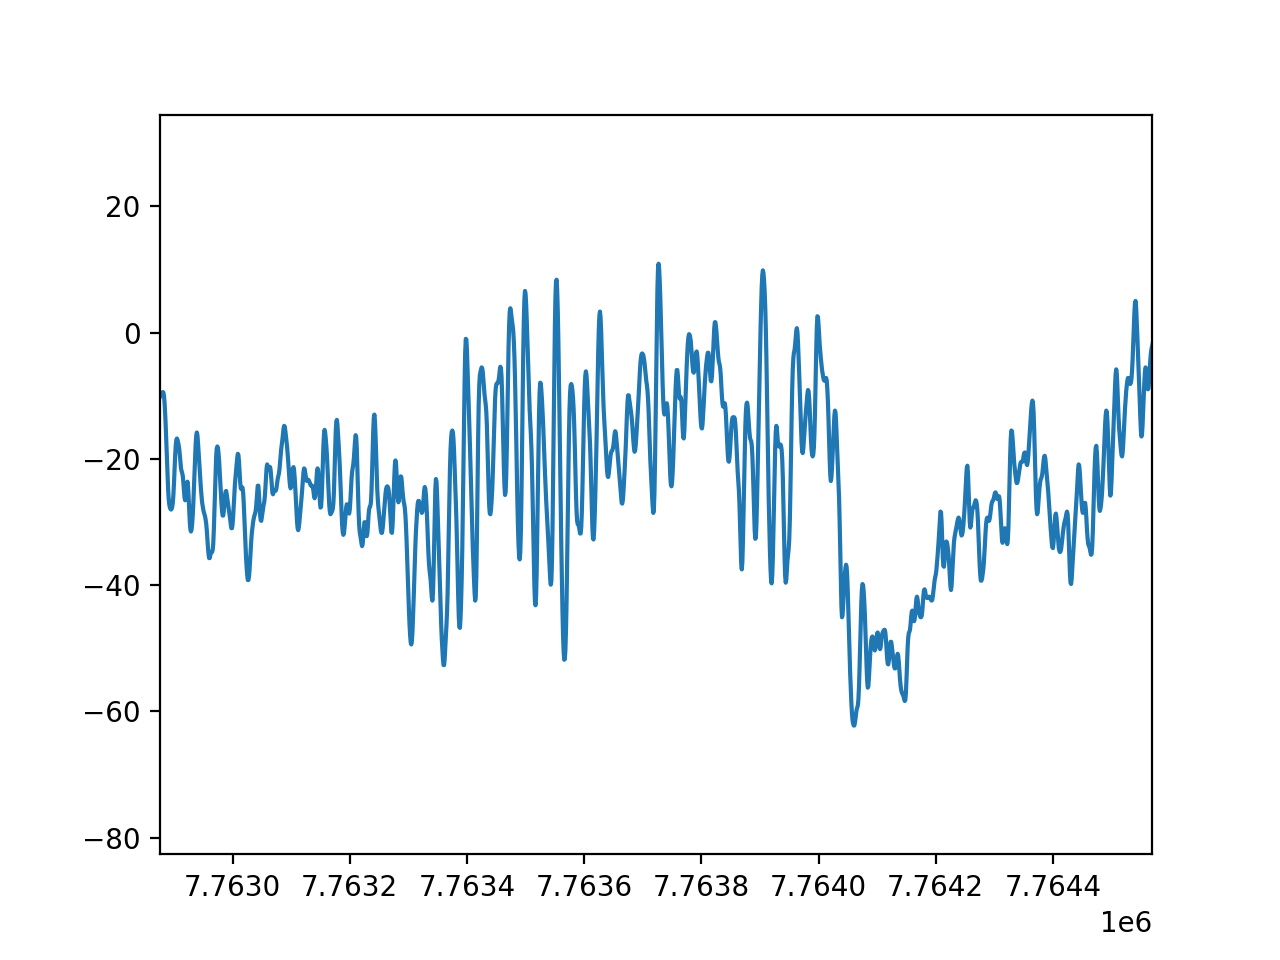

In [65]:
fig, ax = subplots()
ax.plot(X[-4,:])

## Export output

In [86]:
slsh=[i for i in range(0,len(edf_path)) if edf_path[i]=='/']
if not os.path.exists(edf_path[0:slsh[-1]+1]+'event_stats'):
    os.makedirs(edf_path[0:slsh[-1]+1]+'event_stats')

struct = {"Channels":Channels,"fs":fs,"rem_theta_burst_intrv":theta_burst_intrv,"rem_alpha_burst_intrv":alpha_burst_intrv,"rem_beta_burst_intrv":beta_burst_intrv,"rem_theta_burst_count":theta_burst_count,"rem_theta_burst_density":theta_burst_density,"rem_alpha_burst_count":alpha_burst_count,"rem_alpha_burst_density":alpha_burst_density,"rem_beta_burst_count":beta_burst_count,"rem_beta_burst_density":beta_burst_density,"Q_theta_count":Q_theta_count,"Q_theta_density":Q_theta_density,"Q_alpha_count":Q_alpha_count,"Q_alpha_density":Q_alpha_density,"Q_beta_count":Q_beta_count,"Q_beta_density":Q_beta_density}
sio.savemat(edf_path[0:slsh[-1]+1]+'event_stats'+edf_path[slsh[-1]:-4]+'_rem_bursts.mat',struct)


# print('saving spindle outputs to mat...')
# #sio.savemat(edf_path[1:-4]+'_spindles',{"Channels":Channels,"fs":fs,"spindle_intrv_stg2":spindle_intrv_stg2,"spindle_intrv_stg3":spindle_intrv_stg3})
# slsh=[i for i in range(0,len(edf_path)) if edf_path[i]=='/']
# if not os.path.exists(edf_path[0:slsh[-1]+1]+'spindle_stats'):
#     os.makedirs(edf_path[0:slsh[-1]+1]+'spindle_stats')

# struct = {"ch_th_stg2":ch_th_stg2,"ch_th_stg3":ch_th_stg3,"Channels":Channels,"fs":fs,"spindle_intrv_stg2":spindle_intrv_stg2,"spindle_intrv_stg3":spindle_intrv_stg3,"spN_stg2":spN_stg2,"spN_stg3":spN_stg3,"Q_spN_stg2":Q_spN_stg2,"Q_spN_stg3":Q_spN_stg3,"spDns_stg2":spDns_stg2,"spDns_stg3":spDns_stg3,"Q_spDns_stg2":Q_spDns_stg2,"Q_spDns_stg3":Q_spDns_stg3}
# sio.savemat(edf_path[0:slsh[-1]+1]+'spindle_stats'+edf_path[slsh[-1]:-4]+'_spindles',struct)

# print('saving power outputs to mat...')
# Pav_wake, frqs = myPowerUNZIP(P,f,fs,ind0)
# Pav_stg1, frqs = myPowerUNZIP(P,f,fs,ind1)
# Pav_REM, frqs = myPowerUNZIP(P,f,fs,ind5)
# Pav_stg3, frqs = myPowerUNZIP(P,f,fs,ind3)
# Pav_stg2, frqs = myPowerUNZIP(P,f,fs,ind2)

# if not os.path.exists(edf_path[0:slsh[-1]+1]+'PowerSpectra'):
#     os.makedirs(edf_path[0:slsh[-1]+1]+'PowerSpectra')
# structPzip = {"Channels":Channels,"P":P,"frqs":frqs,"fs":fs,"mrk":mrk,"Pav_wake":Pav_wake,"Pav_stg1":Pav_stg1,"Pav_stg2":Pav_stg2,"Pav_stg3":Pav_stg3,"Pav_REM":Pav_REM}
# sio.savemat(edf_path[0:slsh[-1]+1]+'PowerSpectra'+edf_path[slsh[-1]:-4]+'_PwrSpctr',structPzip)



# ################

In [ ]:


# ##### output exports
# spN_stg2=[]
# spN_stg3=[]
# spDns_stg2=[]
# spDns_stg3=[]
# for j in range(0,len(spindle_intrv_stg2)):
#     spN_stg2.append(len(spindle_intrv_stg2[j]))
#     spN_stg3.append(len(spindle_intrv_stg3[j]))
#     spDns_stg2.append(len(spindle_intrv_stg2[j])/(len(ind2)*0.5))
#     spDns_stg3.append(len(spindle_intrv_stg3[j])/(len(ind3)*0.5))

# o=[i for i in range(0,len(mrk)) if mrk[i]>0 and mrk[i]!=7][0]
# e=[i for i in range(0,len(mrk)) if mrk[i]>0 and mrk[i]!=7][-1]
# qs=int((int((e)*30*fs)-int((o-1)*30*fs))/4)
# Q_spN_stg2=[]
# Q_spN_stg3=[]
# Q_spDns_stg2=[]
# Q_spDns_stg3=[]

# for ii in range(0,Q):
#     Q_spN_stg2.append([])
#     Q_spN_stg3.append([])
#     Q_spDns_stg2.append([])
#     Q_spDns_stg3.append([])

# for ii in range(0,4):
#     beg = int((o-1)*30*fs) + ii*qs
#     en = int((o-1)*30*fs) + (ii+1)*qs
#     for j in range(0,len(spindle_intrv_stg2)):
#         cnt=0
#         for i in range(0,len(spindle_intrv_stg2[j])):
#             if spindle_intrv_stg2[j][i][0]>=beg and spindle_intrv_stg2[j][i][0]<en:
#                 cnt+=1
#         Q_spN_stg2[ii].append(cnt)
#         Q_spDns_stg2[ii].append(cnt/(len(ind2)*0.5))

#         cnt=0
#         for i in range(0,len(spindle_intrv_stg3[j])):
#             if spindle_intrv_stg3[j][i][0]>=beg and spindle_intrv_stg3[j][i][0]<en:
#                 cnt+=1
#         Q_spN_stg3[ii].append(cnt)
#         Q_spDns_stg3[ii].append(cnt/(len(ind3)*0.5))
# print('saving spindle outputs to mat...')
# #sio.savemat(edf_path[1:-4]+'_spindles',{"Channels":Channels,"fs":fs,"spindle_intrv_stg2":spindle_intrv_stg2,"spindle_intrv_stg3":spindle_intrv_stg3})
# slsh=[i for i in range(0,len(edf_path)) if edf_path[i]=='/']
# if not os.path.exists(edf_path[0:slsh[-1]+1]+'spindle_stats'):
#     os.makedirs(edf_path[0:slsh[-1]+1]+'spindle_stats')

# struct = {"ch_th_stg2":ch_th_stg2,"ch_th_stg3":ch_th_stg3,"Channels":Channels,"fs":fs,"spindle_intrv_stg2":spindle_intrv_stg2,"spindle_intrv_stg3":spindle_intrv_stg3,"spN_stg2":spN_stg2,"spN_stg3":spN_stg3,"Q_spN_stg2":Q_spN_stg2,"Q_spN_stg3":Q_spN_stg3,"spDns_stg2":spDns_stg2,"spDns_stg3":spDns_stg3,"Q_spDns_stg2":Q_spDns_stg2,"Q_spDns_stg3":Q_spDns_stg3}
# sio.savemat(edf_path[0:slsh[-1]+1]+'spindle_stats'+edf_path[slsh[-1]:-4]+'_spindles',struct)

# print('saving power outputs to mat...')
# Pav_wake, frqs = myPowerUNZIP(P,f,fs,ind0)
# Pav_stg1, frqs = myPowerUNZIP(P,f,fs,ind1)
# Pav_REM, frqs = myPowerUNZIP(P,f,fs,ind5)
# Pav_stg3, frqs = myPowerUNZIP(P,f,fs,ind3)
# Pav_stg2, frqs = myPowerUNZIP(P,f,fs,ind2)

# if not os.path.exists(edf_path[0:slsh[-1]+1]+'PowerSpectra'):
#     os.makedirs(edf_path[0:slsh[-1]+1]+'PowerSpectra')
# structPzip = {"Channels":Channels,"P":P,"frqs":frqs,"fs":fs,"mrk":mrk,"Pav_wake":Pav_wake,"Pav_stg1":Pav_stg1,"Pav_stg2":Pav_stg2,"Pav_stg3":Pav_stg3,"Pav_REM":Pav_REM}
# sio.savemat(edf_path[0:slsh[-1]+1]+'PowerSpectra'+edf_path[slsh[-1]:-4]+'_PwrSpctr',structPzip)


In [48]:
# for i in range(98,len(edf_names)):#49
#     if (edf_names[i] in pbo_names) or (edf_names[i] in zol_names):
#         print(i)
#         edf_path = '/Volumes/Mohsen/PSTIM/allscalp/' + edf_names[i]
#         stages_path = edf_path[0:-3]+'mat'
#         print(edf_path)
#         mySpindleStats(edf_path,stages_path)

100
/Volumes/Mohsen/PSTIM/allscalp/PSTIM_754_V4.edf
reading EDF...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:67: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


reading sleep stages...
calculating power spectra...
estimating spindle peak frequency (Stage 2)...
spindle detection (Stage 2)...
estimating spindle peak frequency (SWS)...
spindle detection (SWS)...
saving spindle outputs to mat...
saving power outputs to mat...
103
/Volumes/Mohsen/PSTIM/allscalp/PSTIM_757_V3.edf
reading EDF...
reading sleep stages...
calculating power spectra...
estimating spindle peak frequency (Stage 2)...
spindle detection (Stage 2)...
estimating spindle peak frequency (SWS)...
spindle detection (SWS)...
saving spindle outputs to mat...
saving power outputs to mat...
104
/Volumes/Mohsen/PSTIM/allscalp/PSTIM_757_V4.edf
reading EDF...
reading sleep stages...
calculating power spectra...
estimating spindle peak frequency (Stage 2)...
spindle detection (Stage 2)...
estimating spindle peak frequency (SWS)...
spindle detection (SWS)...
saving spindle outputs to mat...
saving power outputs to mat...
106
/Volumes/Mohsen/PSTIM/allscalp/PSTIM_758_V2.edf
reading EDF...
read

Populating the interactive namespace from numpy and matplotlib
